# Intrusion Detection Data Generation with GAN

## Install Dependencies and prepare Train, Test Sets

In [34]:
!pip install ctgan
!pip install table_evaluator
!pip install numpy
!pip install gdown
!pip install sdv
!pip install nbformat --upgrade
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from table_evaluator import TableEvaluator
import sdv

## Create Training Dataset and Categorical Columns

In [35]:
train_data = pd.read_csv('KDDTrain.csv')
normal_train_data = train_data.loc[train_data['label'].isin(['normal'])]
dos_train_data = train_data.loc[train_data['label'].isin(['dos'])]
probe_train_data = train_data.loc[train_data['label'].isin(['probe'])]
r2l_train_data = train_data.loc[train_data['label'].isin(['r2l'])]
u2r_train_data = train_data.loc[train_data['label'].isin(['u2r'])]
minority_train_data = train_data.loc[train_data['label'].isin(['u2r','r2l','probe' ])]

categorical_columns = [
    'protocol_type', 'service', 'flag', 'land', 'wrong_fragment', 'urgent',
    'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login', 
    'label'
]
print(train_data.shape[0])
print(minority_train_data.shape[0])

125973
12703


## Train and Save GAN Model With and Without PCA

In [14]:
from sdv.metadata import Metadata
from sdv.single_table import CTGANSynthesizer
import matplotlib.pyplot as plt

def train_and_save_synthesizer(train_data, file_name, table_name='nsl-kdd-minority', epochs=2000, enforce_rounding=True, verbose=True):
    """
    Trains a CTGAN Synthesizer model on the provided training data, saves it to a file, and displays the training loss plot.

    Args:
        train_data (pandas.DataFrame): The training data to be used for synthesizing.
        file_name (str): The path where the trained model will be saved.
        table_name (str): Name of the table for metadata detection. Defaults to 'nsl-kdd-minority'.
        epochs (int): Number of training epochs. Defaults to 2000.
        enforce_rounding (bool): Whether to enforce rounding of the generated data. Defaults to False.
        verbose (bool): Whether to print progress during training. Defaults to True.
    """
    # Detect metadata from the training data
    metadata = Metadata.detect_from_dataframe(data=train_data, table_name=table_name)
    
    # Initialize the CTGAN synthesizer with the detected metadata
    synthesizer = CTGANSynthesizer(
        metadata=metadata,
        enforce_rounding=enforce_rounding,
        epochs=epochs,
        verbose=verbose
    )
    
    # Print the parameters used by the synthesizer (optional)
    print(synthesizer.get_parameters())
    
    # Fit the synthesizer to the training data
    synthesizer.fit(train_data)
    
    # Save the trained model to the specified file
    synthesizer.save(filepath=file_name)
    print(f'Model saved to {file_name}')
    
    # Generate and display the loss values plot
    fig = synthesizer.get_loss_values_plot()
    if fig:
        fig.show()
    else:
        print('No loss values plot available.')


In [7]:
train_and_save_synthesizer(minority_train_data, 'nsl-kdd-gan-minority.pkl')

/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


{'enforce_min_max_values': True, 'enforce_rounding': True, 'locales': ['en_US'], 'embedding_dim': 128, 'generator_dim': (256, 256), 'discriminator_dim': (256, 256), 'generator_lr': 0.0002, 'generator_decay': 1e-06, 'discriminator_lr': 0.0002, 'discriminator_decay': 1e-06, 'batch_size': 500, 'discriminator_steps': 1, 'log_frequency': True, 'verbose': True, 'epochs': 2000, 'pac': 10, 'cuda': True}


Gen. (-1.30) | Discrim. (-0.26): 100%|██████████| 2000/2000 [1:04:13<00:00,  1.93s/it]


Model saved to nsl-kdd-gan-minority.pkl


In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np

def apply_pca(train_data, label_column, n_components):
    """
    Performs PCA on the training data and returns the most important original features
    based on their contributions to principal components.

    Args:
        train_data (pandas.DataFrame): The training data to perform PCA on.
        label_column (str): The name of the label column to exclude from PCA.
        n_components (int): The number of principal components to keep.

    Returns:
        pandas.DataFrame: Transformed data after applying PCA with the label column appended.
        list: List of most important original features from the initial dataset.
    """
    # Separate the label column
    labels = train_data[label_column]
    features = train_data.drop(columns=[label_column])
    
    # Store original column names
    original_feature_names = features.columns.tolist()
    
    # Separate categorical and numeric columns
    categorical_columns = features.select_dtypes(include=['object']).columns
    numeric_columns = features.select_dtypes(exclude=['object']).columns

    # Initialize the transformed data
    transformed_features = features[numeric_columns].copy()
    
    # Handle categorical columns if they exist
    if len(categorical_columns) > 0:
        # Apply One-Hot Encoding
        encoder = OneHotEncoder(sparse=False, drop='first')
        encoded_data = encoder.fit_transform(features[categorical_columns])
        encoded_columns = encoder.get_feature_names_out(categorical_columns)
        
        # Convert encoded data to DataFrame
        encoded_df = pd.DataFrame(
            encoded_data,
            columns=encoded_columns,
            index=features.index
        )
        
        # Combine numeric and encoded categorical data
        transformed_features = pd.concat([transformed_features, encoded_df], axis=1)
    
    # Standardize all features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(transformed_features)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_data)
    
    # Calculate feature importance for original categorical columns
    if len(categorical_columns) > 0:
        # Get importance scores for encoded features
        encoded_importance = np.abs(pca.components_.T) @ np.abs(pca.explained_variance_ratio_)
        
        # Map encoded feature importance back to original categorical columns
        categorical_importance = {}
        current_pos = 0
        
        # Handle numeric columns importance
        for col in numeric_columns:
            categorical_importance[col] = encoded_importance[current_pos]
            current_pos += 1
            
        # Sum importance of encoded columns back to original categorical columns
        for col in categorical_columns:
            # Find all encoded columns for this category
            col_encoded = [c for c in encoded_columns if c.startswith(f"{col}_")]
            # Sum their importance scores
            importance_sum = sum(encoded_importance[current_pos:current_pos + len(col_encoded)])
            categorical_importance[col] = importance_sum
            current_pos += len(col_encoded)
    else:
        # If no categorical columns, use importance scores directly
        categorical_importance = dict(zip(
            numeric_columns,
            np.abs(pca.components_.T) @ np.abs(pca.explained_variance_ratio_)
        ))
    
    # Create importance DataFrame for original features only
    importance_df = pd.DataFrame({
        'feature': original_feature_names,
        'importance': [categorical_importance[col] for col in original_feature_names]
    })
    
    # Sort by importance and select top features
    selected_columns = importance_df.nlargest(
        min(n_components, len(original_feature_names)),
        'importance'
    )['feature'].tolist()
    
    # Create PCA transformed DataFrame
    pca_transformed_df = pd.DataFrame(
        pca_result,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=features.index
    )
    
    # Add back the label column
    pca_transformed_df[label_column] = labels
    
    return pca_transformed_df, selected_columns

In [26]:
pca_transformed_data, selected_columns = apply_pca(train_data, label_column='label', n_components=20)
selected_columns.append('label')
pca_minority_data = minority_train_data[selected_columns]
print(f"Selected columns: {pca_minority_data.columns.tolist()}")
train_and_save_synthesizer(pca_minority_data, 'nsl-kdd-gan-minority-pca.pkl', epochs=2000)

/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



Selected columns: ['service', 'flag', 'protocol_type', 'dst_host_srv_count', 'count', 'logged_in', 'dst_host_same_src_port_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'srv_serror_rate', 'serror_rate', 'dst_host_srv_serror_rate', 'dst_host_serror_rate', 'srv_count', 'diff_srv_rate', 'dst_host_srv_diff_host_rate', 'srv_diff_host_rate', 'dst_host_count', 'rerror_rate', 'srv_rerror_rate', 'label']
{'enforce_min_max_values': True, 'enforce_rounding': True, 'locales': ['en_US'], 'embedding_dim': 128, 'generator_dim': (256, 256), 'discriminator_dim': (256, 256), 'generator_lr': 0.0002, 'generator_decay': 1e-06, 'discriminator_lr': 0.0002, 'discriminator_decay': 1e-06, 'batch_size': 500, 'discriminator_steps': 1, 'log_frequency': True, 'verbose': True, 'epochs': 2000, 'pac': 10, 'cuda': True}


/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/sdv/single_table/base.py:105: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

Gen. (-0.49) | Discrim. (0.01): 100%|██████████| 2000/2000 [47:01<00:00,  1.41s/it] 

Model saved to nsl-kdd-gan-minority-pca.pkl


## Finding Privacy of Columns

In [32]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import check_array
from scipy.sparse import csr_matrix
from scipy.stats import entropy

def prepare_data(X, y):
    """Prepare and validate the data ensuring consistent dimensions."""
    # Ensure labels are encoded if they are categorical
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Preprocessing: One-Hot Encode categorical features
    categorical_cols = X.select_dtypes(include=['object']).columns
    numeric_cols = X.select_dtypes(include=['number']).columns
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(sparse_output=False), categorical_cols),
            ('num', 'passthrough', numeric_cols)
        ]
    )
    
    # Transform the features
    X_processed = preprocessor.fit_transform(X)
    
    # Convert to dense array if sparse
    if isinstance(X_processed, csr_matrix):
        X_processed = X_processed.toarray()
    
    # Get feature names
    if categorical_cols.empty:
        column_mapping = numeric_cols.tolist()
    else:
        column_mapping = (
            preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist() +
            numeric_cols.tolist()
        )
    
    return X_processed, y_encoded, column_mapping

def compute_mutual_info(X, y):
    """Compute mutual information scores for each feature."""
    scores = {}
    for i in range(X.shape[1]):
        scores[i] = mutual_info_score(X[:, i], y)
    return scores

def compute_entropy(X):
    """Compute entropy for each feature."""
    scores = {}
    for i in range(X.shape[1]):
        unique, counts = np.unique(X[:, i], return_counts=True)
        scores[i] = entropy(counts, base=2)
    return scores

def compute_model_scores(X, y, model_class, **model_kwargs):
    """Compute predictive power scores using the specified model."""
    scores = {}
    for i in range(X.shape[1]):
        X_col = X[:, i].reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(
            X_col, y, test_size=0.2, random_state=42
        )
        model = model_class(**model_kwargs)
        model.fit(X_train, y_train)
        scores[i] = model.score(X_test, y_test)
    return scores

def normalize_scores(scores):
    values = list(scores.values())
    min_val = min(values)
    max_val = max(values)
    return {k: (v - min_val) / (max_val - min_val) if max_val > min_val else 0 
            for k, v in scores.items()}

def calculate_privacy_scores(train_data, target_col='label', weights=None):
    """Calculate privacy scores for all features in the dataset."""
    if weights is None:
        weights = {
            'Mutual Information': 0.3,
            'Entropy': 0.3,
            'Naive Bayes Predictive Power': 0.2,
            'KNN Predictive Power': 0.2
        }

    # Separate features and target
    X = train_data.drop(columns=[target_col])
    y = train_data[target_col]
    
    # Prepare the data
    X_processed, y_encoded, column_mapping = prepare_data(X, y)
    
    # Calculate various scores
    mi_scores = normalize_scores(compute_mutual_info(X_processed, y_encoded))
    entropy_scores = normalize_scores(compute_entropy(X_processed))
    nb_scores = normalize_scores(compute_model_scores(X_processed, y_encoded, GaussianNB))
    knn_scores = normalize_scores(compute_model_scores(X_processed, y_encoded, KNeighborsClassifier, n_neighbors=3))
    
    # Combine scores
    privacy_scores = {}
    for i in range(X_processed.shape[1]):
        feature_name = column_mapping[i]
        final_score = (
            weights['Mutual Information'] * mi_scores.get(i, 0) +
            weights['Entropy'] * entropy_scores.get(i, 0) +
            weights['Naive Bayes Predictive Power'] * nb_scores.get(i, 0) +
            weights['KNN Predictive Power'] * knn_scores.get(i, 0)
        )
        privacy_scores[feature_name] = {
            'Mutual Information': mi_scores.get(i, 0),
            'Entropy': entropy_scores.get(i, 0),
            'Naive Bayes Predictive Power': nb_scores.get(i, 0),
            'KNN Predictive Power': knn_scores.get(i, 0),
            'Final Privacy Score': final_score
        }
    
    return privacy_scores


privacy_scores = calculate_privacy_scores(train_data)


/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/tarunannapareddy/.local/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label,

In [33]:
top_privacy_scores = sorted(privacy_scores.items(), key=lambda x: x[1]['Final Privacy Score'], reverse=True)[:10]
print("Top 10 Features by Privacy Score:")
for feature, scores in top_privacy_scores:
    print(f"{feature}: {scores['Final Privacy Score']:.4f}")

Top 10 Features by Privacy Score:
src_bytes: 0.8699
count: 0.7741
dst_host_srv_count: 0.7502
dst_bytes: 0.7419
dst_host_same_srv_rate: 0.6976
dst_host_diff_srv_rate: 0.6949
same_srv_rate: 0.6918
diff_srv_rate: 0.6873
serror_rate: 0.5668
flag_SF: 0.5635


## Load and Run Saved GAN Model

In [40]:
from sdv.single_table import CTGANSynthesizer
import time

start_time = time.time() 
loaded_synthesizer = CTGANSynthesizer.load(filepath='nsl-kdd-gan-minority.pkl')
end_time = time.time()
print(f"API call took {end_time - start_time:.4f} seconds")

API call took 0.0676 seconds


/opt/homebrew/anaconda3/envs/nsl/lib/python3.8/site-packages/sdv/_utils.py:290: SDV Version Warning: You are currently on SDV version 1.17.2 but this synthesizer was created on version 1.17.1. The latest bug fixes and features may not be available for this synthesizer. To see these enhancements, create and train a new synthesizer on this version.
  warnings.warn(message, SDVVersionWarning)


In [41]:
from sdv.sampling import Condition

# Function to generate synthetic data and append to the CSV file
def generate_and_append_synthetic_data(csv_file, label, num_rows, synthesizer):
    # Load the existing CSV file
    df = pd.read_csv(csv_file)
    
    # Define the condition to generate synthetic data for the specified label
    condition = Condition(num_rows=num_rows, column_values={'label': label})
    start_time = time.time() 
    # Generate synthetic data
    synthetic_data = synthesizer.sample_from_conditions(conditions=[condition])
    end_time = time.time()
    print(f"API call took {end_time - start_time:.4f} seconds")
    # Round all numeric columns to 2 decimal places
    synthetic_data = synthetic_data.round(2)
    
    # Concatenate the generated synthetic data with the original dataframe
    updated_df = pd.concat([df, synthetic_data], ignore_index=True)
    
    # Overwrite the original CSV file with the updated dataframe
    updated_df.to_csv(csv_file, index=False)
    
    print(f"Synthetic data for label '{label}' added to {csv_file}")

In [42]:
csv_file = 'KDDTrainSynthatic.CSV'
generate_and_append_synthetic_data(csv_file, 'u2r', 2000, loaded_synthesizer)
generate_and_append_synthetic_data(csv_file, 'r2l', 2000, loaded_synthesizer)

Sampling conditions: 100%|██████████| 2000/2000 [00:02<00:00, 997.67it/s] 


API call took 2.0070 seconds
Synthetic data for label 'u2r' added to KDDTrainSynthatic.CSV


Sampling conditions: 100%|██████████| 2000/2000 [00:00<00:00, 2855.88it/s]


API call took 0.7021 seconds
Synthetic data for label 'r2l' added to KDDTrainSynthatic.CSV


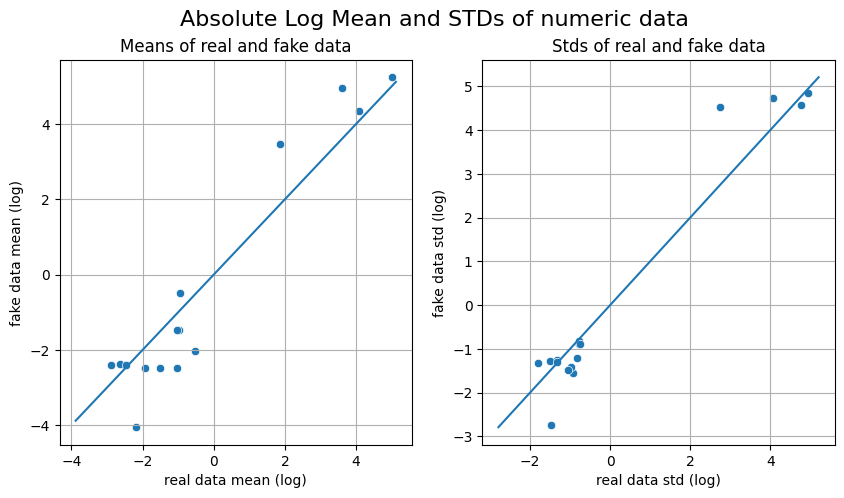

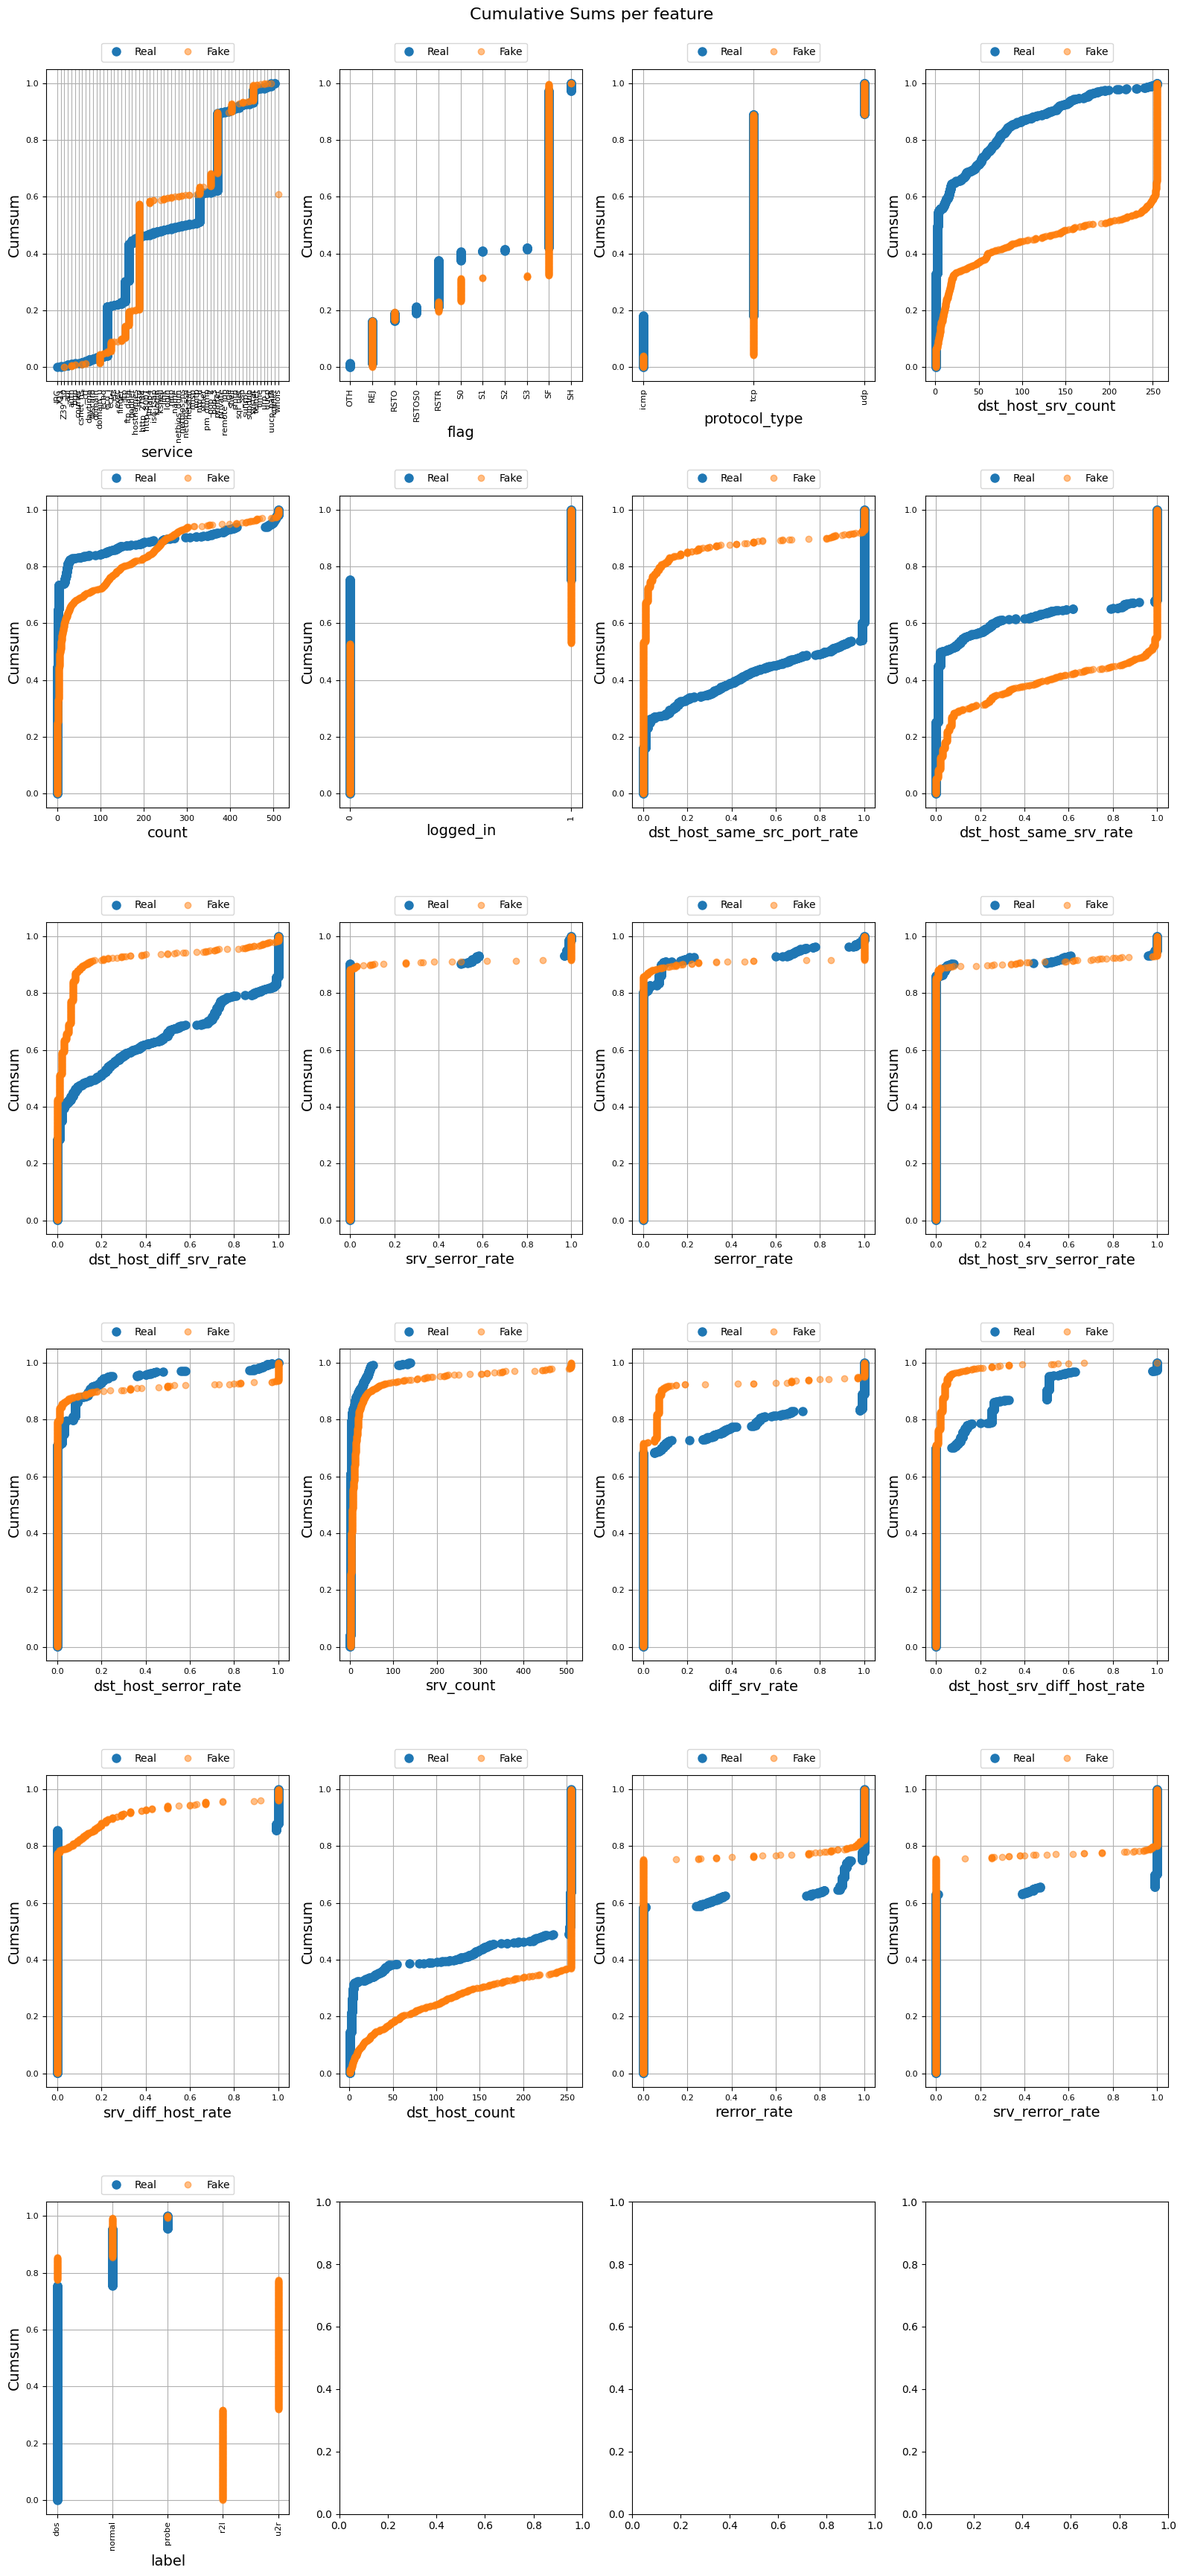

/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

FixedFormatter should only be used together with FixedLocator

/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

FixedFormatter should only be used together with FixedLocator

/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

FixedFormatter should only be used together with FixedLocator

/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

FixedFormatter should only be used together with FixedLocator

/opt/homebrew/anaconda3/envs/ctgan/lib/python3.8/site-packages/table_evaluator/table_evaluator.py:182: UserWarning:

FixedFormatter should only be used together with FixedLocator



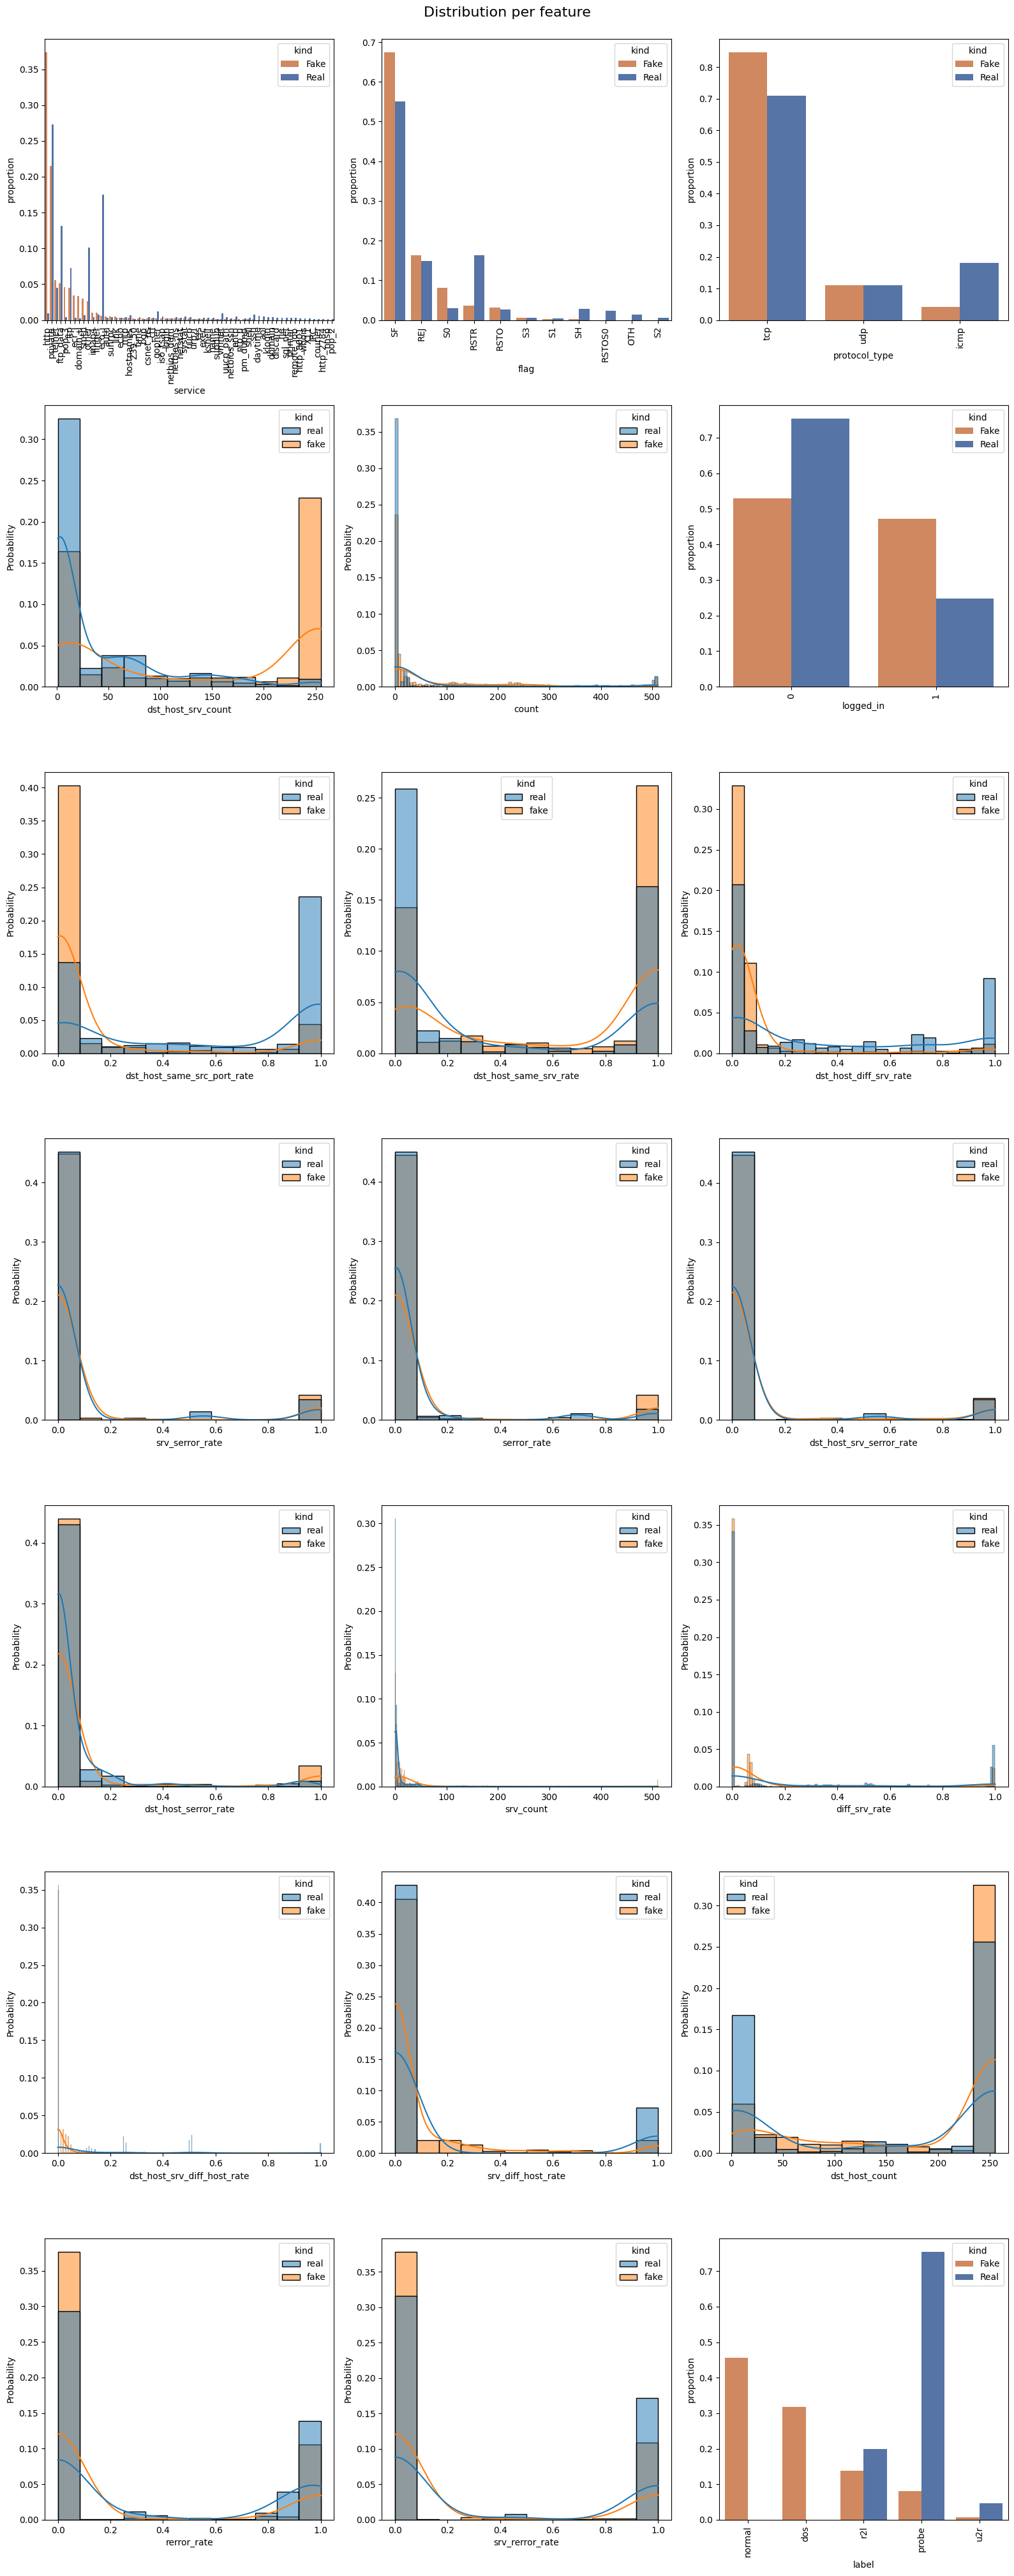

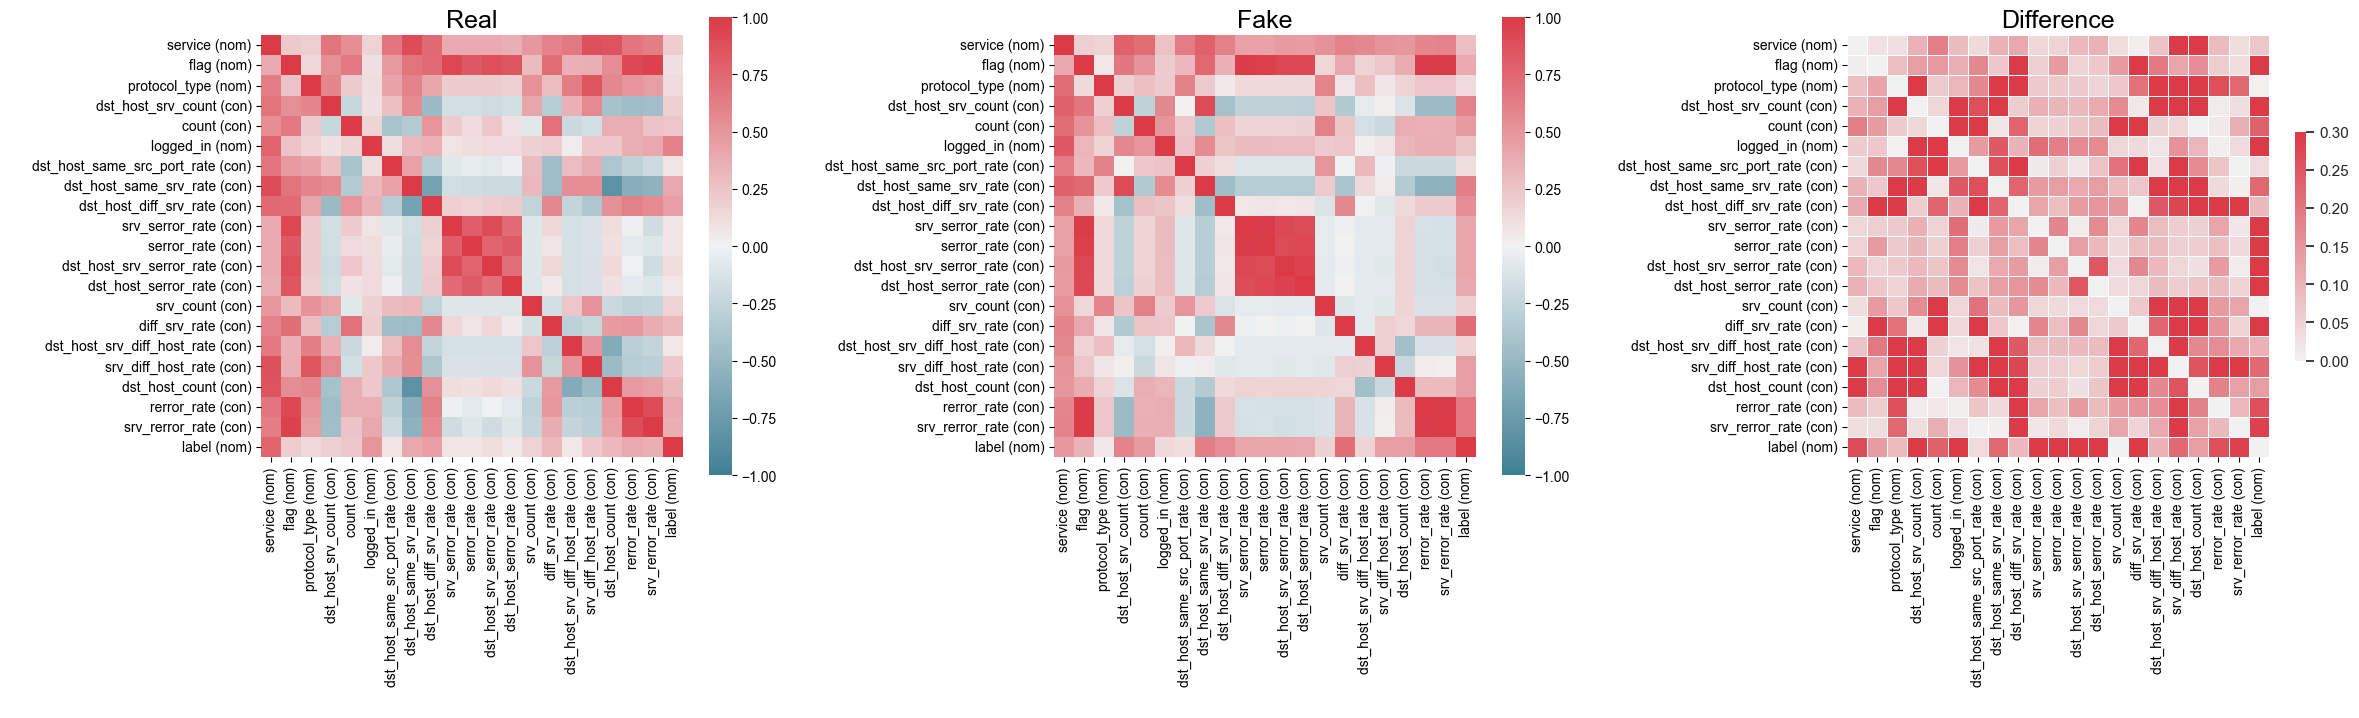

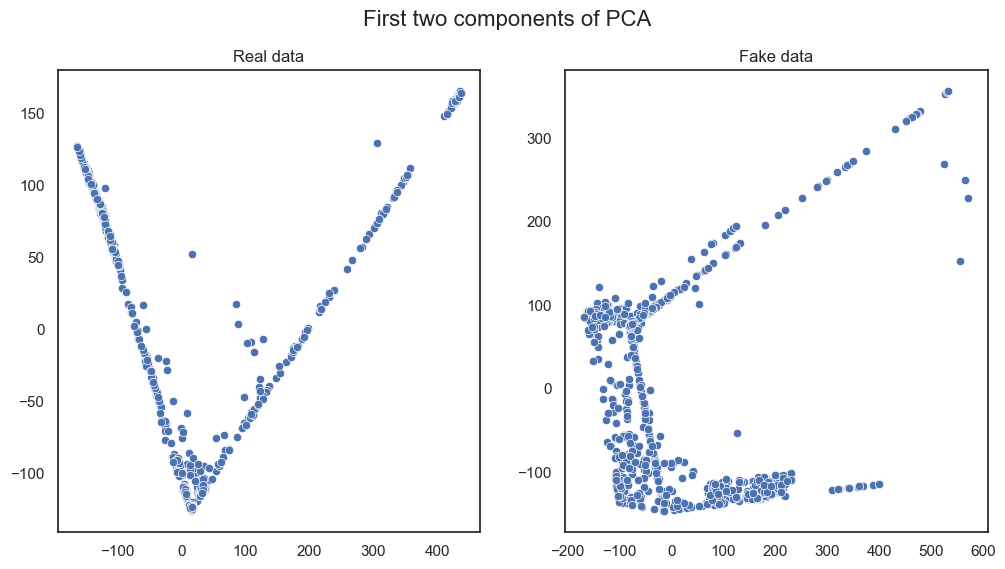

In [35]:
test_data = pd.read_csv('KDDTest.csv')
cols = ['service', 'flag', 'protocol_type', 'dst_host_srv_count', 'count', 'logged_in', 'dst_host_same_src_port_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'srv_serror_rate', 'serror_rate', 'dst_host_srv_serror_rate', 'dst_host_serror_rate', 'srv_count', 'diff_srv_rate', 'dst_host_srv_diff_host_rate', 'srv_diff_host_rate', 'dst_host_count', 'rerror_rate', 'srv_rerror_rate', 'label']
#train_data['value'] = pd.to_numeric(test_data['value'], errors='coerce')
#test_data['timestamp'] = pd.to_datetime(test_data['timestamp'], unit='ms')
#test_data['timestamp'] = test_data['timestamp'].astype(int) / 10**9

table_evaluator =  TableEvaluator(loaded_synthesizer.sample(1000), test_data[cols], cat_cols = ['protocol_type', 'service', 'flag', 'logged_in', 'label'])

table_evaluator.visual_evaluation()